## Importazione delle principali librerie

In [1]:
import warnings

# Ignora il warning di sklearn riguardante i nomi delle feature durante la PCA
warnings.filterwarnings("ignore", message="X does not have valid feature names, but PCA was fitted with feature names", category=UserWarning)

In [2]:
import pandas as pd
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle

from skimage import color

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Definizione di costanti

In [4]:
COLOR_IMAGE_SIZE = (3, 80, 80)
IMAGE_SIZE = (3, 80, 80)

ORIGINAL_DATASET_PATH = 'drive/MyDrive/ML/projFinale/shipsnet.json'
FINAL_DATASET_PATH = 'drive/MyDrive/ML/projFinale/ablationdata_gray.csv'
NN_WEIGHTS_PATH = "drive/MyDrive/ML/projFinale/ablationship_nn_weights.h5"
NN_CONFIG_PATH = "drive/MyDrive/ML/projFinale/ablationship_nn_config.json"
SVM_MODEL_DUMP_PATH = "drive/MyDrive/ML/projFinale/ablationsvmAddestratoSuTuttoDataset.pkl"

RANDOM_STATE = 57
(TRAINING_SET_SIZE, VALIDATION_SET_SIZE, TEST_SET_SIZE) = (0.7, 0.2, 0.1)

EPSILON = 1e-6

In [5]:
assert abs(TRAINING_SET_SIZE + VALIDATION_SET_SIZE + TEST_SET_SIZE - 1) < EPSILON, "Invalid split sizes"

__Random seed__ per la riproducibilità degli esperimenti:

In [6]:
np.random.seed(RANDOM_STATE)

## Importazione del dataset

Il dataset è una raccolta di __immagini satelittari__ *RGB* di dimensioni $3 \times 80 \times 80$, etichettate nella seguente maniera:
 - _1_: L'immagine contiene una __nave completa__;
 - _0_: L'immagine non contiene una nave (o contiene soltanto una parte di una nave);

In [7]:
with open(ORIGINAL_DATASET_PATH) as f:
    dataset = json.load(f)

dataset.keys()

dict_keys(['data', 'labels', 'locations', 'scene_ids'])

In [8]:
df = pd.DataFrame(np.array(dataset['data'], dtype=np.uint8))
df['labels'] = dataset['labels']
df.head()

,0,1,2,3,4,5,6,7,8,9,...,19191,19192,19193,19194,19195,19196,19197,19198,19199,labels
0,82,89,91,87,89,87,86,86,86,86,...,87,87,85,84,85,86,86,88,89,1
1,76,75,67,62,68,72,73,73,68,69,...,53,51,54,52,54,56,54,57,58,1
2,125,127,129,130,126,125,129,133,132,130,...,116,122,118,116,118,117,111,109,115,1
3,102,99,113,106,96,102,105,105,103,106,...,62,68,73,80,93,89,94,95,77,1
4,78,76,74,78,79,79,79,82,86,85,...,86,86,87,84,84,85,85,86,83,1


Dimensioni del dataset:

In [9]:
df.shape

(4000, 19201)

Tipi delle features:

In [10]:
df.dtypes

0         uint8
1         uint8
2         uint8
3         uint8
4         uint8
          ...  
19196     uint8
19197     uint8
19198     uint8
19199     uint8
labels    int64
Length: 19201, dtype: object

## Pre-processamento del dataset

 Visualizzazione di alcune immagini casuali del dataset originale:

In [11]:
n_images_to_show = 10
n_images_per_row = 5

In [12]:
random_indexes = df.sample(n=n_images_to_show, random_state=RANDOM_STATE).index

Normalizzazione del nuovo dataset:

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(scaler.fit_transform(np.array(dataset['data']).astype('uint8')))

df = pd.DataFrame(scaled_data)

df["labels"] = dataset["labels"]
print("Normalized dataset dimension: ", df.shape) # 4000 x 19201

Normalized dataset dimension:  (4000, 19201)


Salvataggio del nuovo dataset in scala di grigi:

## Esplorazione del dataset

Importazione del dataset modificato:

In [14]:
dataset = df
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,19191,19192,19193,19194,19195,19196,19197,19198,19199,labels
0,-0.367295,-0.202086,-0.156337,-0.255318,-0.215134,-0.264477,-0.286256,-0.289458,-0.284247,-0.279008,...,-0.112946,-0.111198,-0.156120,-0.183496,-0.157644,-0.131615,-0.127391,-0.066084,-0.037103,1
1,-0.507858,-0.531112,-0.719967,-0.843554,-0.708561,-0.613805,-0.588135,-0.593375,-0.705630,-0.673915,...,-1.060437,-1.115751,-1.030344,-1.097548,-1.040685,-0.981152,-1.033385,-0.946537,-0.920162,1
2,0.640068,0.690983,0.736077,0.756448,0.654237,0.620489,0.712265,0.809321,0.792622,0.743105,...,0.695207,0.865450,0.774507,0.730556,0.782367,0.746241,0.580416,0.530353,0.703528,1
3,0.101246,0.032932,0.360324,0.191741,-0.050659,0.084852,0.154951,0.154729,0.113727,0.185589,...,-0.809630,-0.641379,-0.494529,-0.297753,0.070237,-0.046661,0.099107,0.132728,-0.378932,1
4,-0.461004,-0.507610,-0.555575,-0.467083,-0.450099,-0.450785,-0.448806,-0.382971,-0.284247,-0.302238,...,-0.140814,-0.139103,-0.099718,-0.183496,-0.186129,-0.159933,-0.155703,-0.122887,-0.208017,1


Dimensione del dataset:

In [15]:
dataset.shape

(4000, 19201)

Tipi delle features:

In [16]:
dataset.dtypes

0         float64
1         float64
2         float64
3         float64
4         float64
           ...   
19196     float64
19197     float64
19198     float64
19199     float64
labels      int64
Length: 19201, dtype: object

### Suddivisione del dataset in __training set__ , __validation test__ e __test set__
Si opta per una divisione del tipo:
 - $70\%$ __training set__
 - $20\%$ __validation set__
 - $10\%$ __test set__

In [17]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(dataset.drop("labels", axis=1), dataset["labels"], test_size=TEST_SET_SIZE, random_state=RANDOM_STATE)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=VALIDATION_SET_SIZE / (TRAINING_SET_SIZE + VALIDATION_SET_SIZE), random_state=RANDOM_STATE)

In [19]:
assert abs(X_train.shape[0] - dataset.shape[0] * TRAINING_SET_SIZE) <= 1, "Invalid training split size: " + str(X_train.shape[0]) + " instead of " + str(dataset.shape[0] * TRAINING_SET_SIZE)
assert abs(X_val.shape[0] - dataset.shape[0] * VALIDATION_SET_SIZE) <= 1, "Invalid validation split size: " + str(X_val.shape[0]) + " instead of " + str(dataset.shape[0] * VALIDATION_SET_SIZE)

## Ricampionamento del training set

Per equilibrare le classi del __training set__, utilizziamo sia l'**oversampling** della classe meno rappresentata che che l'**undersampling** di quella più rappresentata.

Distribuzione iniziale delle classe del __training set__:

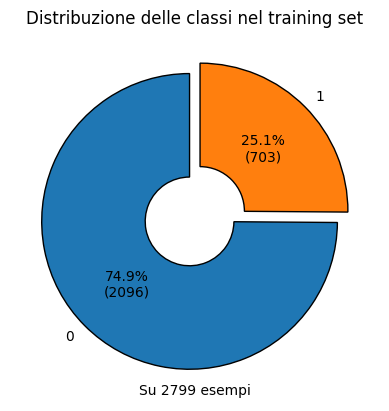

In [20]:
target_features_number = dict(y_train.value_counts())

plt.pie(target_features_number.values(), labels=target_features_number.keys(),
                autopct=lambda pct : f"{pct:.1f}%\n({round(pct/100*len(X_train))})",
                startangle=90,
                wedgeprops=dict(edgecolor=(0, 0, 0, 1), width=0.7),
                explode=[0.05, 0.05])

plt.title("Distribuzione delle classi nel training set")
plt.text(0, -1.2, f"Su {len(X_train)} esempi", ha='center')

plt.show()

In [21]:
resized_X_train = X_train.copy()
resized_y_train = y_train.copy()

### Undersampling per la classe minoritaria

In [22]:
pos_proportion = 0.333  # percentuale della classe positiva che vogliamo ottenere dall'undersampling (pos / (pos + neg))

pos_to_neg_proportion = pos_proportion / (1 - pos_proportion)   # rapporto tra le classi positiva e negativa che vogliamo ottenere (pos / neg)
neg_elem_to_remove = round(target_features_number[0] - target_features_number[1] * (1 - pos_proportion) / pos_proportion)   # numero di elementi negativi da rimuovere
print(f"Desired proportion of positive examples: {pos_proportion:.3f} --> pos / (pos + neg)")
print(f"Desired proportion of positive to negative examples: {pos_to_neg_proportion:.3f} --> pos / neg")
print(f"Negative examples to remove: {neg_elem_to_remove}, {neg_elem_to_remove / target_features_number[0] * 100:.1f}% of the actual negative examples")

Desired proportion of positive examples: 0.333 --> pos / (pos + neg)
Desired proportion of positive to negative examples: 0.499 --> pos / neg
Negative examples to remove: 688, 32.8% of the actual negative examples


In [23]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(sampling_strategy=pos_to_neg_proportion, random_state=RANDOM_STATE)
resized_X_train, resized_y_train = undersampler.fit_resample(resized_X_train, resized_y_train)
resized_X_train.shape

(2111, 19200)

In [24]:
resized_y_train.value_counts()

0    1408
1     703
Name: labels, dtype: int64

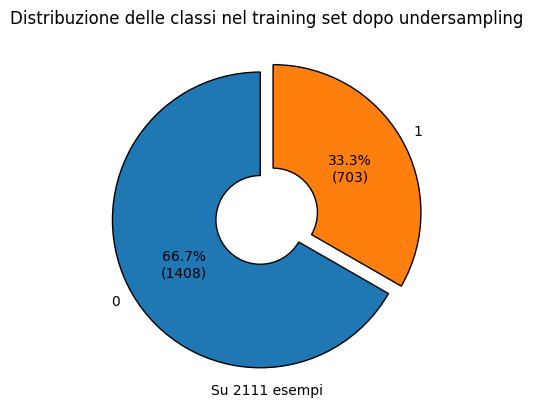

In [25]:
target_features_number = dict(resized_y_train.value_counts())

plt.pie(target_features_number.values(), labels=target_features_number.keys(),
        autopct=lambda pct : f"{pct:.1f}%\n({round(pct/100*len(resized_X_train))})",
        startangle=90,
        wedgeprops=dict(edgecolor=(0, 0, 0, 1), width=0.7),
        explode=[0.05, 0.05])

plt.title("Distribuzione delle classi nel training set dopo undersampling")
plt.text(0, -1.2, f"Su {len(resized_X_train)} esempi", ha='center')
plt.show()


### Oversampling per la classe maggioritaria

In [26]:
pos_proportion = 0.4    # percentuale della classe positiva che vogliamo ottenere dall'oversampling (pos / (pos + neg))

pos_to_neg_proportion = pos_proportion / (1 - pos_proportion)   # rapporto tra le classi positiva e negativa che vogliamo ottenere (pos / neg)
pos_elem_to_generate = round(target_features_number[0] - target_features_number[1] * (1 - pos_proportion) / pos_proportion)   # numero di elementi negativi da rimuovere
print(f"Desired proportion of positive examples: {pos_proportion:.3f} --> pos / (pos + neg)")
print(f"Desired proportion of positive to negative examples: {pos_to_neg_proportion:.3f} --> pos / neg")
print(f"Positive examples to generate: {pos_elem_to_generate}, {pos_elem_to_generate / target_features_number[0] * 100:.1f}% of the actual positive examples")

Desired proportion of positive examples: 0.400 --> pos / (pos + neg)
Desired proportion of positive to negative examples: 0.667 --> pos / neg
Positive examples to generate: 354, 25.1% of the actual positive examples


In [27]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(sampling_strategy=pos_to_neg_proportion, random_state=RANDOM_STATE)
resized_X_train, resized_y_train = oversampler.fit_resample(resized_X_train, resized_y_train)
resized_y_train.shape

(2346,)

In [28]:
resized_y_train.value_counts()

0    1408
1     938
Name: labels, dtype: int64

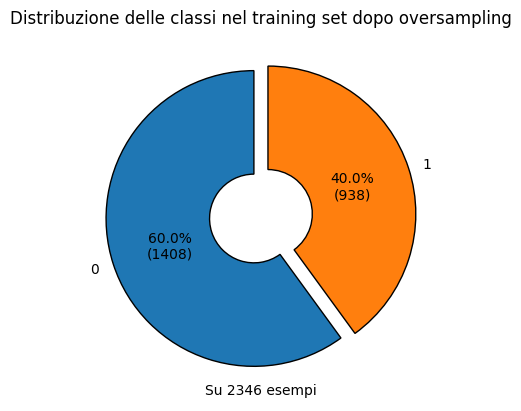

In [29]:
target_features_number = dict(resized_y_train.value_counts())

plt.pie(target_features_number.values(), labels=target_features_number.keys(),
        autopct=lambda pct : f"{pct:.1f}%\n({round(pct/100*len(resized_X_train))})",
        startangle=90,
        wedgeprops=dict(edgecolor=(0, 0, 0, 1), width=0.7),
        explode=[0.05, 0.05])

plt.title("Distribuzione delle classi nel training set dopo oversampling")
plt.text(0, -1.2, f"Su {len(resized_X_train)} esempi", ha='center')
plt.show()

## __PCA__ - Principal Components Analysis

Percentuali di __varianza spiegata__ di riferimento:

In [30]:
target_var = [0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

Calcolo della varianza spiegata da ogni componente:

In [31]:
from sklearn.decomposition import PCA

pca = PCA().fit(resized_X_train)

### Analisi del numero ottimale di componenti da utilizzare:

Varianza spiegata: 0.6 -> Componenti necessarie: 5
Varianza spiegata: 0.7 -> Componenti necessarie: 10
Varianza spiegata: 0.8 -> Componenti necessarie: 26
Varianza spiegata: 0.9 -> Componenti necessarie: 92
Varianza spiegata: 0.95 -> Componenti necessarie: 212
Varianza spiegata: 0.99 -> Componenti necessarie: 679


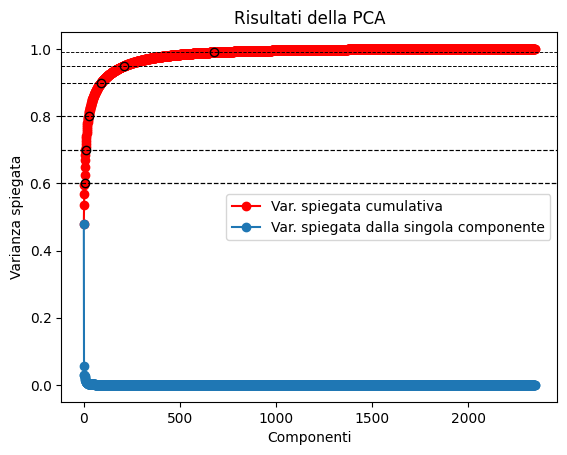

In [32]:
tot_var_explained = []
prev_var_explained = 0
n_comp_for_target_var = []

for i, comp_var_explained in enumerate(pca.explained_variance_ratio_):
    tot_var_explained.append(prev_var_explained + comp_var_explained)
    prev_var_explained += comp_var_explained
    if len(n_comp_for_target_var) < len(target_var) and prev_var_explained >= target_var[len(n_comp_for_target_var)]:
        n_comp_for_target_var.append(i + 1)

for var, n_comp in zip(target_var, n_comp_for_target_var):
    print("Varianza spiegata: {} -> Componenti necessarie: {}".format(var, n_comp))

# Crea un grafico della varianza spiegata per ogni componente
plt.plot(range(1, pca.n_components_ + 1), tot_var_explained, marker='o', color='red', label="Var. spiegata cumulativa")
for i, crit_val in enumerate(n_comp_for_target_var):
    plt.plot(crit_val, target_var[i], marker='o', color='red', markeredgecolor='black')

plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o', label="Var. spiegata dalla singola componente")
for i, var in enumerate(target_var):
    plt.axhline(y=var, color='black', linestyle='--', linewidth=0.9 - i * 0.05)

plt.xlabel('Componenti')
plt.ylabel('Varianza spiegata')
plt.title("Risultati della PCA")
plt.legend()

plt.show()

In [33]:
assert abs(sum(pca.explained_variance_ratio_) - 1) <= EPSILON, "La somma della varianza spiegata dalle singole componenti non è 1"

In [34]:
max_component_index = 3

max_var_n_comp = n_comp_for_target_var[max_component_index]
max_var_n_comp

92

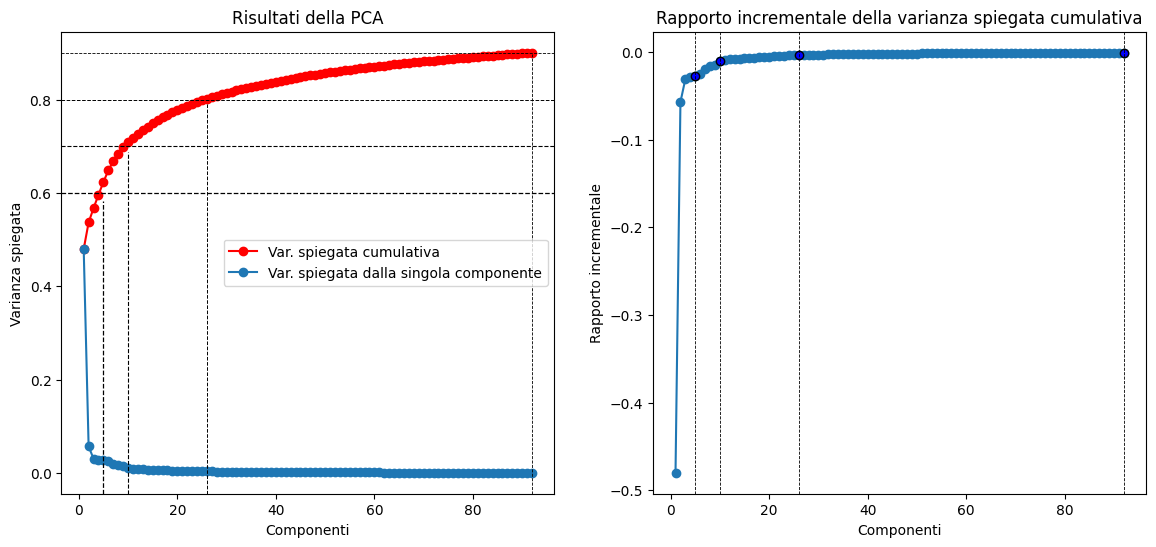

In [35]:
tot_var_explained = []
prev_var_explained = 0
incr_ratio = []

for i in range(max_var_n_comp):
    comp_var_explained = pca.explained_variance_ratio_[i]
    tot_var_explained.append(prev_var_explained + comp_var_explained)
    if i > 0:
        incr_ratio.append(tot_var_explained[-2] - tot_var_explained[-1])
    else:
        incr_ratio.append(0 - tot_var_explained[-1])
    prev_var_explained += comp_var_explained

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Crea un grafico della varianza spiegata per ogni componente
ax[0].plot(range(1, max_var_n_comp + 1), tot_var_explained, marker='o', color='red', label="Var. spiegata cumulativa")
ax[0].plot(range(1, max_var_n_comp + 1), pca.explained_variance_ratio_[:max_var_n_comp], marker='o', label="Var. spiegata dalla singola componente")
for i, var in enumerate(target_var[:max_component_index + 1]):
    ax[0].axhline(y=var, color='black', linestyle='--', linewidth=0.9 - i * 0.1)
    ax[0].axvline(x=n_comp_for_target_var[i], ymax=var/ax[0].get_ylim()[1], color='black', linestyle='--', linewidth=0.9 - i * 0.1)

ax[0].set_xlabel('Componenti')
ax[0].set_ylabel('Varianza spiegata')
ax[0].set_title("Risultati della PCA")
ax[0].legend()

# Crea un grafico del rapporto incrementale per ogni componente
ax[1].plot(range(1, max_var_n_comp + 1), incr_ratio, marker='o', label="Rapporto incrementale")
for crit_val in n_comp_for_target_var[:max_component_index + 1]:
    ax[1].plot(crit_val, incr_ratio[crit_val - 1], marker='o', color='blue', markeredgecolor='black')
    ax[1].axvline(x=crit_val, color='black', linestyle='--', linewidth=0.9 - i * 0.1)
ax[1].set_xlabel('Componenti')
ax[1].set_ylabel('Rapporto incrementale')
ax[1].set_title("Rapporto incrementale della varianza spiegata cumulativa")

plt.show()

Analisi numerica del numero di componenti:

In [36]:
APPROX = 6

data = []
for i, ratio in enumerate([0 - incr_ratio[0]] + [incr_ratio[i+1] - incr_ratio[i] for i in range(len(incr_ratio) - 1)]):
    data.append([i+1, round(tot_var_explained[i], APPROX), round(incr_ratio[i], APPROX), round(ratio, APPROX)])

df = pd.DataFrame(data, columns=['Numero di componenti', 'Varianza spiegata cumulativa', 'Derivata prima', 'Derivata seconda'])
df

,Numero di componenti,Varianza spiegata cumulativa,Derivata prima,Derivata seconda
0,1,0.479948,-0.479948,0.479948
1,2,0.536918,-0.056970,0.422978
2,3,0.567651,-0.030733,0.026237
3,4,0.596097,-0.028447,0.002286
4,5,0.623585,-0.027488,0.000959
...,...,...,...,...
87,88,0.897731,-0.000761,0.000012
88,89,0.898479,-0.000748,0.000013
89,90,0.899223,-0.000744,0.000003
90,91,0.899952,-0.000729,0.000016


In [37]:
pca = PCA(n_components=max_var_n_comp).fit(resized_X_train)

Riepilogo dei valori di __varianza spiegata__ dalle componenti selezionate. Le colonne 1 e 2 dovrebbero coincidere a meno di errori di approsimazione: la differenza deriva dalle __operazioni di bilanciamento__ del dataset.

In [38]:
eigenvalues = pca.explained_variance_
n_samples = resized_X_train.shape[0]
cov_matrix = np.dot(resized_X_train.T, resized_X_train) / n_samples

data = []
for eigenvalue, eigenvector in zip(eigenvalues, pca.components_):
    data.append([np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)), eigenvalue])

df_eigen = pd.DataFrame(data, columns=['Covarianza', 'Autovalore'])
df_eigen['Autovalore normalizzato'] = df_eigen['Autovalore'] / df_eigen['Autovalore'].sum()
df_eigen['Somma cumulativa'] = df_eigen['Autovalore normalizzato'].cumsum()

df_eigen

,Covarianza,Autovalore,Autovalore normalizzato,Somma cumulativa
0,9029.811793,9015.810182,0.532928,0.532928
1,1094.094571,1070.182221,0.063259,0.596186
2,577.131985,577.313269,0.034125,0.630312
3,534.258194,534.369214,0.031587,0.661898
4,516.908700,516.352366,0.030522,0.692420
...,...,...,...,...
87,14.093744,14.098981,0.000833,0.996780
88,13.915650,13.918783,0.000823,0.997603
89,13.780947,13.775323,0.000814,0.998417
90,13.469772,13.464541,0.000796,0.999213


In [39]:
assert abs(sum(df_eigen['Autovalore normalizzato']) - 1) <= EPSILON, "La somma degli autovalori normalizzati non è 1"

Estrazione del numero di componenti finale:

In [40]:
n_components = 84

In [41]:
pca = PCA(n_components=n_components).fit(resized_X_train)

### Trasformazione dei vari __set__ nelle componenti selezionate

__Training set__:

In [42]:
pca_X_train = pca.transform(resized_X_train)
pca_X_train.shape

(2346, 84)

Ricerca di eventuali correlazioni tra le componenti del __training set__ dopo la pca:

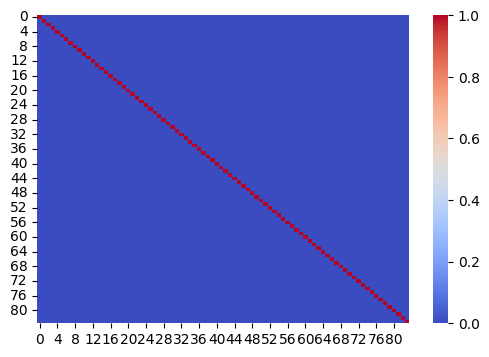

In [43]:
correlation_matrix = pd.DataFrame(pca_X_train).corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()

__Validation set__

In [44]:
pca_X_val = pca.transform(X_val)
pca_X_val.shape

(801, 84)

Ricerca di eventuali correlazioni tra le componenti del __validation set__ dopo la pca:

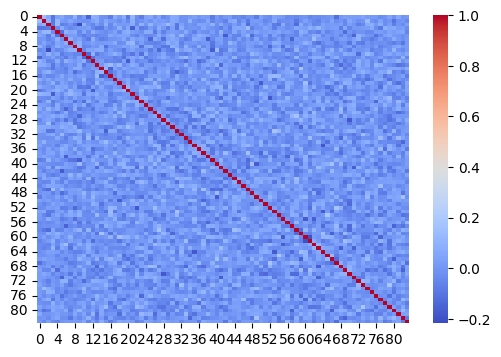

In [45]:
correlation_matrix = pd.DataFrame(pca_X_val).corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()

__Test set__

In [46]:
pca_X_test = pca.transform(X_test)
pca_X_test.shape

(400, 84)

Ricerca di eventuali correlazioni tra le componenti del __test set__ dopo la pca:

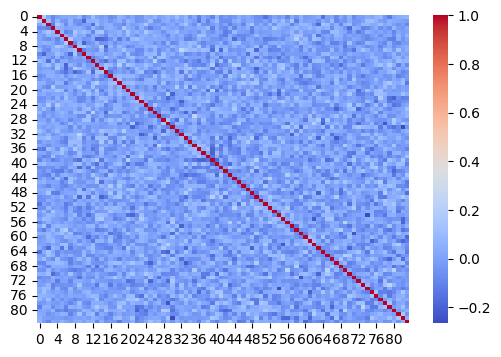

In [47]:
correlation_matrix = pd.DataFrame(pca_X_test).corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()

In [48]:
assert resized_y_train.shape[0] == pca_X_train.shape[0], "Il numero di esempi nel training set dopo la PCA è diverso dal numero di labels"

In [49]:
assert y_val.shape[0] == pca_X_val.shape[0], "Il numero di esempi nel validation set dopo la PCA è diverso dal numero di labels"

In [50]:
assert y_test.shape[0] == pca_X_test.shape[0], "Il numero di esempi nel test set dopo la PCA è diverso dal numero di labels"

## __Modello 1__ - __Rete neurale__

Verrà utilizzata una rete neurale con _uno strato nascosto_:
 - La __funzione di loss__ per l'addestramento sarà ___binary crossentropy___;
 - La __funzione di attivazione__ per lo strato di ouput (o meglio, il nodo di ouput) sarà ___sigmoid___.

Per tutti gli altri _iperparametri_ verrà fatta una ricerca degli ottimi.

### Impostazione dei __random seed__ per la riproducibilità degli addestramenti

In [51]:
import tensorflow as tf

tf.random.set_seed(RANDOM_STATE)

### Ricerca della migliore __funzione di attivazione__ per lo strato nascosto

In [52]:
activations_avaible = ['exponential', 'hard_sigmoid', 'linear', 'relu', 'selu', 'elu', 'gelu', 'sigmoid', 'softmax', 'softplus', 'softsign', 'swish', 'tanh', 'mish']
activations_accuracy = []
epochs = 10
batch_size = 15
hidden_layer_nodes = n_components//2

In [53]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score, explained_variance_score
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)  # Arresta l'addestramento se la loss sulla validation set non migliora per 5 epoche consecutive

activations_accuracy = []
activations_explained_variance = []

for i, activation in enumerate(activations_avaible):
    print(f"Testing activation function: {activation} ({i+1}/{len(activations_avaible)}):", end="\r")
    model = Sequential()
    model.add(Dense(hidden_layer_nodes, input_shape=(n_components,), activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(pca_X_train, resized_y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stopping], validation_data=(pca_X_val, y_val))

    y_pred = model.predict(pca_X_val)
    threshold = 0.5
    y_pred = (y_pred > threshold).astype(int)
    activations_accuracy.append(accuracy_score(y_val, y_pred))
    activations_explained_variance.append(explained_variance_score(y_val, y_pred))
    print(f"Activation: {activation}, Accuracy: {activations_accuracy[-1]:.3f}, Explained Variance: {activations_explained_variance[-1]:.3f}")

26/26 [==============================] - 0s 1ms/step
Activation: exponential, Accuracy: 0.757, Explained Variance: 0.000
26/26 [==============================] - 0s 3ms/step
Activation: hard_sigmoid, Accuracy: 0.938, Explained Variance: 0.664
26/26 [==============================] - 0s 2ms/step
Activation: linear, Accuracy: 0.915, Explained Variance: 0.546
26/26 [==============================] - 0s 4ms/step
Activation: relu, Accuracy: 0.950, Explained Variance: 0.729
26/26 [==============================] - 0s 2ms/step
Activation: selu, Accuracy: 0.951, Explained Variance: 0.737
26/26 [==============================] - 0s 3ms/step
Activation: elu, Accuracy: 0.943, Explained Variance: 0.691
26/26 [==============================] - 0s 2ms/step
Activation: gelu, Accuracy: 0.949, Explained Variance: 0.724
26/26 [==============================] - 0s 2ms/step
Activation: sigmoid, Accuracy: 0.940, Explained Variance: 0.679
26/26 [==============================] - 0s 1ms/step
Activation: soft

In [54]:
threshold = 0.985
max_accuracy = max(activations_accuracy)
best_activations_quad = [(activations_avaible[i], acc, expl) for i, (acc, expl) in enumerate(zip(activations_accuracy, activations_explained_variance)) if acc >= max_accuracy * threshold]

for activation, accuracy, expl in best_activations_quad:
    print(f"{activation}: Accuracy = {accuracy:.4f} --> {accuracy / max_accuracy:.3f} of max accuracy, explained variance = {expl:.3f}")

relu: Accuracy = 0.9501 --> 0.993 of max accuracy, explained variance = 0.729
selu: Accuracy = 0.9513 --> 0.995 of max accuracy, explained variance = 0.737
elu: Accuracy = 0.9426 --> 0.986 of max accuracy, explained variance = 0.691
gelu: Accuracy = 0.9488 --> 0.992 of max accuracy, explained variance = 0.724
softplus: Accuracy = 0.9563 --> 1.000 of max accuracy, explained variance = 0.765
swish: Accuracy = 0.9488 --> 0.992 of max accuracy, explained variance = 0.723
mish: Accuracy = 0.9451 --> 0.988 of max accuracy, explained variance = 0.706


In [55]:
batch_size = 5
hidden_layer_nodes = [n_components//2 - 5, n_components//2, n_components//2 + 5]
epochs = 10

target_metric_str = "f1"

best_activations, best_activations_accuracy, best_activations_explained_var = zip(*best_activations_quad)
best_activations

('relu', 'selu', 'elu', 'gelu', 'softplus', 'swish', 'mish')

In [56]:
from sklearn.metrics import f1_score, explained_variance_score
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)

activations_best_parameters = []

for i, activation in enumerate(best_activations):
    print(f"Testing activation function: {activation} ({i+1}/{len(best_activations)})")
    target_metric, best_nodes = 0, 0
    for j, nodes in enumerate(hidden_layer_nodes):
        print(f"Testing with {nodes} hidden nodes ({j+1}/{len(hidden_layer_nodes)})", end="\r")
        model = Sequential()
        model.add(Dense(nodes, input_shape=(n_components,), activation=activation))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(pca_X_train, resized_y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(pca_X_val, y_val), callbacks=[early_stopping])

        y_pred = model.predict(pca_X_val)
        threshold = 0.5
        y_pred = (y_pred > threshold).astype(int)
        f1 = f1_score(y_val, y_pred)
        if f1 > target_metric:
            target_metric = f1
            accuracy = accuracy_score(y_val, y_pred)
            explained_variance = explained_variance_score(y_val, y_pred)
            best_nodes = nodes
    activations_best_parameters.append((activation, target_metric, accuracy, explained_variance, best_nodes ))
    print(f"Best {target_metric_str}: {target_metric:.3f} with {best_nodes} hidden nodes, Accuracy = {accuracy:.3f}, explained variance = {explained_variance:.3f}")

Testing activation function: relu (1/7)
26/26 [==============================] - 0s 1ms/step
Best f1: 0.937 with 47 hidden nodes, Accuracy = 0.969, explained variance = 0.831
Testing activation function: selu (2/7)
26/26 [==============================] - 0s 2ms/step
Best f1: 0.917 with 42 hidden nodes, Accuracy = 0.958, explained variance = 0.772
Testing activation function: elu (3/7)
26/26 [==============================] - 0s 2ms/step
Best f1: 0.926 with 42 hidden nodes, Accuracy = 0.963, explained variance = 0.798
Testing activation function: gelu (4/7)
26/26 [==============================] - 0s 1ms/step
Best f1: 0.939 with 42 hidden nodes, Accuracy = 0.970, explained variance = 0.838
Testing activation function: softplus (5/7)
26/26 [==============================] - 0s 2ms/step
Best f1: 0.942 with 47 hidden nodes, Accuracy = 0.971, explained variance = 0.845
Testing activation function: swish (6/7)
26/26 [==============================] - 0s 1ms/step
Best f1: 0.927 with 42 hidde

In [57]:
activations_best_parameters

[('relu', 0.9367088607594937, 0.968789013732834, 0.8307523059998307, 47),
 ('selu', 0.9166666666666666, 0.9575530586766542, 0.7722772277227723, 42),
 ('elu', 0.9257425742574258, 0.9625468164794008, 0.7983075230599983, 42),
 ('gelu', 0.9393939393939394, 0.9700374531835206, 0.8376237623762376, 42),
 ('softplus', 0.9420654911838792, 0.9712858926342073, 0.8445121435220444, 47),
 ('swish', 0.9273182957393483, 0.9637952559300874, 0.8041127189642041, 42),
 ('mish', 0.9249999999999999, 0.9625468164794008, 0.7974951341287975, 37)]

In [58]:
activations, target_metric, accuracy, explained_var, nodes = zip(*activations_best_parameters)

In [59]:
best_index_metrics = np.argmax(target_metric)
best_activation_function, target_metric, accuracy, explained_var, best_nodes = activations_best_parameters[best_index_metrics]
print(f"Best activation function is: {best_activation_function} with {best_nodes} hidden nodes --> Accuracy = {accuracy}, F1 = {target_metric}, Explained Variance = {explained_var}")

Best activation function is: softplus with 47 hidden nodes --> Accuracy = 0.9712858926342073, F1 = 0.9420654911838792, Explained Variance = 0.8445121435220444


A causa di fattori probabilistici della libreria __keras__ (come la inizializzazione dei pesi), la migliore funzione di attivazione può variare da esecuzione a esecuzione. Per questo viene scelta la funzione ___mish___, quella che ha dato risultati migliori negli esperimenti eseguiti.

In [60]:
best_activation_function = 'mish'
best_activation_function

'mish'

### Ricerca della migliore __architettura__ per lo strato nascosto della rete
Si eseguono diverse prove facendo variare il __numero di nodi__ dello __strato nascosto__.

In [61]:
epochs = 50
batch_size = 5
patience = 10

base_cardinality = n_components//2
lower_bound = base_cardinality//2
upper_bound = 3 * (base_cardinality//2)
multiplier = 5

hidden_layer_nodes = [hidden_nodes for hidden_nodes in range(lower_bound, upper_bound, multiplier)]

In [62]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, explained_variance_score
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=patience)  # Arresta l'addestramento se la loss sulla validation set non migliora per _patience_ epoche consecutive

accuracy = []
recall = []
precision = []
f1 = []
explained_variance = []
best_epochs = []

for i, nodes in enumerate(hidden_layer_nodes):
    print(f"Testing hidden layer dimension: {nodes} ({i+1}/{len(hidden_layer_nodes)})")
    model = Sequential()
    model.add(Dense(nodes, input_shape=(n_components,), activation=best_activation_function)) # nodes=#nodi strato nascosto, varia di iterazione in iterazione
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(pca_X_train, resized_y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stopping], validation_data=(pca_X_val, y_val))
    best_epochs.append(len(history.history['val_loss']))

    y_pred = model.predict(pca_X_val)
    threshold = 0.5
    y_pred = (y_pred > threshold).astype(int)

    accuracy.append(accuracy_score(y_val, y_pred))
    recall.append(recall_score(y_val, y_pred))
    precision.append(precision_score(y_val, y_pred))
    f1.append(f1_score(y_val, y_pred))
    explained_variance.append(explained_variance_score(y_val, y_pred))

    print(f'Hidden nodes: {nodes}, Best epochs: {best_epochs[-1]},  Accuracy: {accuracy[-1]}, F1: {f1[-1]}, Explained Variance: {explained_variance[-1]}')

Testing hidden layer dimension: 21 (1/9)
26/26 [==============================] - 0s 1ms/step
Hidden nodes: 21, Best epochs: 20,  Accuracy: 0.9612983770287141, F1: 0.9238329238329237, Explained Variance: 0.7923161546923922
Testing hidden layer dimension: 26 (2/9)
26/26 [==============================] - 0s 2ms/step
Hidden nodes: 26, Best epochs: 23,  Accuracy: 0.9525593008739076, F1: 0.905940594059406, Explained Variance: 0.7440805619023441
Testing hidden layer dimension: 31 (3/9)
26/26 [==============================] - 0s 2ms/step
Hidden nodes: 31, Best epochs: 20,  Accuracy: 0.9588014981273408, F1: 0.9185185185185185, Explained Variance: 0.7782178217821782
Testing hidden layer dimension: 36 (4/9)
26/26 [==============================] - 0s 1ms/step
Hidden nodes: 36, Best epochs: 25,  Accuracy: 0.9637952559300874, F1: 0.9280397022332506, Explained Variance: 0.8048574088178049
Testing hidden layer dimension: 41 (5/9)
26/26 [==============================] - 0s 2ms/step
Hidden nodes: 4

In [63]:
for i, nodes in enumerate(hidden_layer_nodes):
    print(f'Hidden nodes: {nodes}, epochs: {best_epochs[i]}, Accuracy: {accuracy[i]}, Recall: {recall[i]}, Precision: {precision[i]}, F1: {f1[i]}, Explained variance score: {explained_variance[i]}')

Hidden nodes: 21, epochs: 20, Accuracy: 0.9612983770287141, Recall: 0.9641025641025641, Precision: 0.8867924528301887, F1: 0.9238329238329237, Explained variance score: 0.7923161546923922
Hidden nodes: 26, epochs: 23, Accuracy: 0.9525593008739076, Recall: 0.9384615384615385, Precision: 0.8755980861244019, F1: 0.905940594059406, Explained variance score: 0.7440805619023441
Hidden nodes: 31, epochs: 20, Accuracy: 0.9588014981273408, Recall: 0.9538461538461539, Precision: 0.8857142857142857, F1: 0.9185185185185185, Explained variance score: 0.7782178217821782
Hidden nodes: 36, epochs: 25, Accuracy: 0.9637952559300874, Recall: 0.958974358974359, Precision: 0.8990384615384616, F1: 0.9280397022332506, Explained variance score: 0.8048574088178049
Hidden nodes: 41, epochs: 18, Accuracy: 0.9563046192259675, Recall: 0.9333333333333333, Precision: 0.8921568627450981, F1: 0.9122807017543859, Explained variance score: 0.7634424980959634
Hidden nodes: 46, epochs: 20, Accuracy: 0.9600499375780275, Re

In [64]:
best_nodes = hidden_layer_nodes[np.argmax(f1)]
best_nodes

51

In [65]:
epochs = 50
batch_size = 5
patience = 10

hidden_layer_nodes = [best_nodes + i  for i in range(1 - multiplier, multiplier)]

In [66]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, explained_variance_score
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=patience)  # Arresta l'addestramento se la loss sulla validation set non migliora per _patience_ epoche consecutive

accuracy = []
recall = []
precision = []
f1 = []
explained_variance = []
best_epochs = []

for i, nodes in enumerate(hidden_layer_nodes):
    print(f"Testing hidden layer dimesions: {nodes} ({i+1}/{len(hidden_layer_nodes)})")
    model = Sequential()
    model.add(Dense(nodes, input_shape=(n_components,), activation=best_activation_function)) # nodes = #nodi strato nascosto, varia di iterazione in iterazione
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(pca_X_train, resized_y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stopping], validation_data=(pca_X_val, y_val))
    best_epochs.append(len(history.history['val_loss']))

    y_pred = model.predict(pca_X_val)
    threshold = 0.5
    y_pred = (y_pred > threshold).astype(int)

    accuracy.append(accuracy_score(y_val, y_pred))
    recall.append(recall_score(y_val, y_pred))
    precision.append(precision_score(y_val, y_pred))
    f1.append(f1_score(y_val, y_pred))
    explained_variance.append(explained_variance_score(y_val, y_pred))

    print(f'Hidden nodes: {nodes}, Best epochs: {best_epochs[-1]},  Accuracy: {accuracy[-1]}, F1: {f1[-1]}, Explained Variance: {explained_variance[-1]}')

Testing hidden layer dimesions: 47 (1/9)
26/26 [==============================] - 0s 2ms/step
Hidden nodes: 47, Best epochs: 20,  Accuracy: 0.9600499375780275, F1: 0.9203980099502488, Explained Variance: 0.7843107387661843
Testing hidden layer dimesions: 48 (2/9)
26/26 [==============================] - 0s 1ms/step
Hidden nodes: 48, Best epochs: 28,  Accuracy: 0.9712858926342073, F1: 0.94147582697201, Explained Variance: 0.8441736481340442
Testing hidden layer dimesions: 49 (3/9)
26/26 [==============================] - 0s 1ms/step
Hidden nodes: 49, Best epochs: 23,  Accuracy: 0.9675405742821473, F1: 0.9346733668341708, Explained Variance: 0.8243039688584243
Testing hidden layer dimesions: 50 (4/9)
26/26 [==============================] - 0s 1ms/step
Hidden nodes: 50, Best epochs: 20,  Accuracy: 0.9675405742821473, F1: 0.934010152284264, Explained Variance: 0.8238977743928239
Testing hidden layer dimesions: 51 (5/9)
26/26 [==============================] - 0s 2ms/step
Hidden nodes: 51,

In [67]:
for i, nodes in enumerate(hidden_layer_nodes):
    print(f'Hidden nodes: {nodes}, epochs: {best_epochs[i]}, Accuracy: {accuracy[i]}, Recall: {recall[i]}, Precision: {precision[i]}, F1: {f1[i]}, Explained variance score: {explained_variance[i]}')

Hidden nodes: 47, epochs: 20, Accuracy: 0.9600499375780275, Recall: 0.9487179487179487, Precision: 0.893719806763285, F1: 0.9203980099502488, Explained variance score: 0.7843107387661843
Hidden nodes: 48, epochs: 28, Accuracy: 0.9712858926342073, Recall: 0.9487179487179487, Precision: 0.9343434343434344, F1: 0.94147582697201, Explained variance score: 0.8441736481340442
Hidden nodes: 49, epochs: 23, Accuracy: 0.9675405742821473, Recall: 0.9538461538461539, Precision: 0.916256157635468, F1: 0.9346733668341708, Explained variance score: 0.8243039688584243
Hidden nodes: 50, epochs: 20, Accuracy: 0.9675405742821473, Recall: 0.9435897435897436, Precision: 0.9246231155778895, F1: 0.934010152284264, Explained variance score: 0.8238977743928239
Hidden nodes: 51, epochs: 20, Accuracy: 0.9675405742821473, Recall: 0.9435897435897436, Precision: 0.9246231155778895, F1: 0.934010152284264, Explained variance score: 0.8238977743928239
Hidden nodes: 52, epochs: 23, Accuracy: 0.9675405742821473, Recall

In [68]:
target_metric_best_index = np.argmax(f1)
print(f"Best hidden nodes number: {hidden_layer_nodes[target_metric_best_index]}, epochs: {best_epochs[target_metric_best_index]}, Accuracy: {accuracy[target_metric_best_index]}, Recall: {recall[target_metric_best_index]}, Precision: {precision[target_metric_best_index]}, F1: {f1[target_metric_best_index]}, Explained variance score: {explained_variance[target_metric_best_index]}")

Best hidden nodes number: 48, epochs: 28, Accuracy: 0.9712858926342073, Recall: 0.9487179487179487, Precision: 0.9343434343434344, F1: 0.94147582697201, Explained variance score: 0.8441736481340442


In [69]:
best_nodes = hidden_layer_nodes[target_metric_best_index]

In [70]:
batch_size = 5
epochs = best_epochs[target_metric_best_index]

Vengono fissati anche il numero di nodi e di epoche ottimale in base a quanto riscontrato durante gli esperimenti:

In [118]:
best_nodes, epochs = 53, 22
best_nodes, epochs, best_activation_function

(53, 22, 'mish')

### __Stratified 10-fold cross validation__

Ricostruzione del __training_val_set__ (__training set + validation set__):

In [203]:
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])
y = y_train_val

In [204]:
assert X_train_val.shape[0] == y_train_val.shape[0], "Training + validation set have different number of examples and labels"

In [205]:
pca_cross_dataset = pca.transform(X_train_val)
df = pd.DataFrame(data=pca_cross_dataset)

In [206]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, explained_variance_score
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from keras.models import Sequential
from keras.layers import Dense

In [207]:
n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=RANDOM_STATE)

test_pred_proba = np.zeros((df.shape[0], 2))
accuracy_k_fold = []
recall_k_fold = []
precision_k_fold = []
f1_k_fold = []
explained_variance_k_fold = []
timesAddestramento = []
timesInferenza = []

early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)

resample = False
undersampling_pos_proportion, oversampling_pos_proportion = 0.333, 0.4
undersampling_pos_to_neg_proportion = undersampling_pos_proportion / (1 - undersampling_pos_proportion)
oversampling_pos_to_neg_proportion = oversampling_pos_proportion / (1 - oversampling_pos_proportion)
undersampler = RandomUnderSampler(sampling_strategy=undersampling_pos_to_neg_proportion, random_state=RANDOM_STATE)
oversampler = RandomOverSampler(sampling_strategy=oversampling_pos_to_neg_proportion, random_state=RANDOM_STATE)

for n_fold, (train_idx, val_test_idx) in enumerate(folds.split(df, y)):
        X_cross_train, X_cross_val = df.iloc[train_idx], df.iloc[val_test_idx]
        y_cross_train, y_cross_val = y[train_idx], y[val_test_idx]

        if resample:
                X_cross_train, y_cross_train = undersampler.fit_resample(X_cross_train, y_cross_train)
                X_cross_train, y_cross_train = oversampler.fit_resample(X_cross_train, y_cross_train)

        model = Sequential()
        model.add(Dense(best_nodes, input_shape=(n_components,), activation=best_activation_function))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        tic = time.time()
        model.fit(X_cross_train, y_cross_train, epochs=epochs, batch_size=batch_size,
                  verbose=0, validation_data=(X_cross_val, y_cross_val), callbacks=[early_stopping])
        timesAddestramento.append(time.time() - tic)

        tic = time.time()
        y_cross_pred_valid = model.predict(X_cross_val)
        timesInferenza.append(time.time() - tic)

        threshold = 0.5
        y_cross_pred_valid = (y_cross_pred_valid > threshold).astype(int)

        accuracy_k_fold.append(accuracy_score(y_cross_val, y_cross_pred_valid))
        recall_k_fold.append(recall_score(y_cross_val, y_cross_pred_valid))
        precision_k_fold.append(precision_score(y_cross_val, y_cross_pred_valid))
        f1_k_fold.append(f1_score(y_cross_val, y_cross_pred_valid))
        explained_variance_k_fold.append(explained_variance_score(y_cross_val, y_cross_pred_valid))

        print(f'Fold {n_fold + 1}, Accuracy: {accuracy_k_fold[-1]:.3f}, F1: {f1_k_fold[-1]:.3f}, Explained Variance: {explained_variance_k_fold[-1]:.3f}', end=", ")
        print(f'Training time: {timesAddestramento[-1]:.3f}, Evaluation time: {timesInferenza[-1]:.3f}')

12/12 [==============================] - 0s 2ms/step
Fold 1, Accuracy: 0.983, F1: 0.966, Explained Variance: 0.911, Training time: 41.639, Evaluation time: 0.152
12/12 [==============================] - 0s 2ms/step
Fold 2, Accuracy: 0.967, F1: 0.933, Explained Variance: 0.821, Training time: 18.217, Evaluation time: 0.145
12/12 [==============================] - 0s 2ms/step
Fold 3, Accuracy: 0.975, F1: 0.950, Explained Variance: 0.867, Training time: 15.760, Evaluation time: 5.522
12/12 [==============================] - 0s 7ms/step
Fold 4, Accuracy: 0.967, F1: 0.934, Explained Variance: 0.822, Training time: 15.493, Evaluation time: 0.501
12/12 [==============================] - 0s 2ms/step
Fold 5, Accuracy: 0.975, F1: 0.951, Explained Variance: 0.867, Training time: 21.678, Evaluation time: 2.812
12/12 [==============================] - 0s 2ms/step
Fold 6, Accuracy: 0.986, F1: 0.973, Explained Variance: 0.926, Training time: 27.696, Evaluation time: 0.179
12/12 [=====================

Metriche sul __validation test__ per la __stratified cross validation__:

In [208]:
print(f"Tempo medio di addestramento: {np.mean(timesAddestramento):.2f} secondi")
print(f"Tempo medio di inferenza: {np.mean(timesInferenza):.2f} secondi")

Tempo medio di addestramento: 21.34 secondi
Tempo medio di inferenza: 4.21 secondi


In [209]:
accuracy = np.mean(accuracy_k_fold)
recall = np.mean(recall_k_fold)
precision = np.mean(precision_k_fold)
f1 = np.mean(f1_k_fold)
explained_variance = np.mean(explained_variance_k_fold)
print(f"Accuracy={accuracy:.3f}, Recall={recall:.3f}, Precision={precision:.3f}, F1={f1:.3f}, Explained Variance={explained_variance:.3f}")

Accuracy=0.971, Recall=0.951, Precision=0.936, F1=0.943, Explained Variance=0.847


In [210]:
confidence = 0.95

Intervalli di confidenza per tutte le metriche:

In [211]:
import scipy.stats as stats

print(f"Accuracy {confidence} confidence interval: {stats.t.interval(confidence=confidence, df=len(accuracy_k_fold)-1, loc=np.mean(accuracy_k_fold), scale=stats.sem(accuracy_k_fold))}")
print(f"Recall {confidence} confidence interval: {stats.t.interval(confidence=confidence, df=len(recall_k_fold)-1, loc=np.mean(recall_k_fold), scale=stats.sem(recall_k_fold))}")
print(f"Precision {confidence} confidence interval: {stats.t.interval(confidence=confidence, df=len(precision_k_fold)-1, loc=np.mean(precision_k_fold), scale=stats.sem(precision_k_fold))}")
print(f"F1 {confidence} confidence interval: {stats.t.interval(confidence=confidence, df=len(f1_k_fold)-1, loc=np.mean(f1_k_fold), scale=stats.sem(f1_k_fold))}") # dopo lo plottiamo assieme all'intervallo dell'f1 score dell'svm
print(f"Explained Variance {confidence} confidence interval: {stats.t.interval(confidence=confidence, df=len(explained_variance_k_fold)-1, loc=np.mean(explained_variance_k_fold), scale=stats.sem(explained_variance_k_fold))}")

Accuracy 0.95 confidence interval: (0.9595753272074573, 0.9832024505703204)
Recall 0.95 confidence interval: (0.9310561446686508, 0.9709163896634342)
Precision 0.95 confidence interval: (0.9085102670058008, 0.9635294902556754)
F1 0.95 confidence interval: (0.9204589378760564, 0.9662021628731192)
Explained Variance 0.95 confidence interval: (0.7846393531229301, 0.9102939895604758)


### __Addestramento__ con l'intero __training set__

In [212]:
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])

In [213]:
assert X_train_val.shape[0] == y_train_val.shape[0], "Training + validation set have different number of examples and labels"

In [214]:
resample = True

undersampling_pos_proportion, oversampling_pos_proportion = 0.333, 0.4
undersampling_pos_to_neg_proportion = undersampling_pos_proportion / (1 - undersampling_pos_proportion)
oversampling_pos_to_neg_proportion = oversampling_pos_proportion / (1 - oversampling_pos_proportion)
undersampler = RandomUnderSampler(sampling_strategy=undersampling_pos_to_neg_proportion, random_state=RANDOM_STATE)
oversampler = RandomOverSampler(sampling_strategy=oversampling_pos_to_neg_proportion, random_state=RANDOM_STATE)

if resample:
    X_train_val, y_train_val = undersampler.fit_resample(X_train_val, y_train_val)
    X_train_val, y_train_val = oversampler.fit_resample(X_train_val, y_train_val)

In [215]:
pca_train_dataset = pca.transform(X_train_val)

In [216]:
model = Sequential()
model.add(Dense(best_nodes, input_shape=(n_components,), activation=best_activation_function))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

tic = time.time()
model.fit(pca_train_dataset, y_train_val, epochs=epochs, batch_size=batch_size, verbose=1)
training_time = time.time() - tic

print(f"Training time: {training_time:.2f} seconds")

Epoch 1/22
600/600 [==============================] - 2s 3ms/step - loss: 0.6182 - accuracy: 0.8725
Epoch 2/22
600/600 [==============================] - 1s 2ms/step - loss: 0.1501 - accuracy: 0.9516
Epoch 3/22
600/600 [==============================] - 1s 2ms/step - loss: 0.0952 - accuracy: 0.9676
Epoch 4/22
600/600 [==============================] - 1s 2ms/step - loss: 0.0616 - accuracy: 0.9780
Epoch 5/22
600/600 [==============================] - 1s 2ms/step - loss: 0.0430 - accuracy: 0.9856
Epoch 6/22
600/600 [==============================] - 1s 2ms/step - loss: 0.0245 - accuracy: 0.9927
Epoch 7/22
600/600 [==============================] - 1s 2ms/step - loss: 0.0152 - accuracy: 0.9960
Epoch 8/22
600/600 [==============================] - 1s 2ms/step - loss: 0.0220 - accuracy: 0.9933
Epoch 9/22
600/600 [==============================] - 1s 2ms/step - loss: 0.0255 - accuracy: 0.9897
Epoch 10/22
600/600 [==============================] - 1s 2ms/step - loss: 0.0108 - accuracy: 0.9970

### Test finale sul test-set e matrice di confusione

In [217]:
y_test_pred_prob_nn = model.predict(pca_X_test) #questi valori saranno utili nella sezione test finale della svm, dove formeranno dei grafici congiunti con i rispettivi dati dell'svm
threshold = 0.5
y_test_pred_valid = (y_test_pred_prob_nn > threshold).astype(int)

accuracy_nn = accuracy_score(y_test, y_test_pred_valid)
recall_nn = recall_score(y_test, y_test_pred_valid)
precision_nn = precision_score(y_test, y_test_pred_valid)
f1_nn = f1_score(y_test, y_test_pred_valid)
explained_variance_nn = explained_variance_score(y_test, y_test_pred_valid)

print(f"Accuracy={accuracy_nn:.3f}, Recall={recall_nn:.3f}, Precision={precision_nn:.3f}, F1={f1_nn:.3f}, Explained Variance={explained_variance_nn:.3f}")

13/13 [==============================] - 0s 2ms/step
Accuracy=0.970, Recall=0.941, Precision=0.941, F1=0.941, Explained Variance=0.842


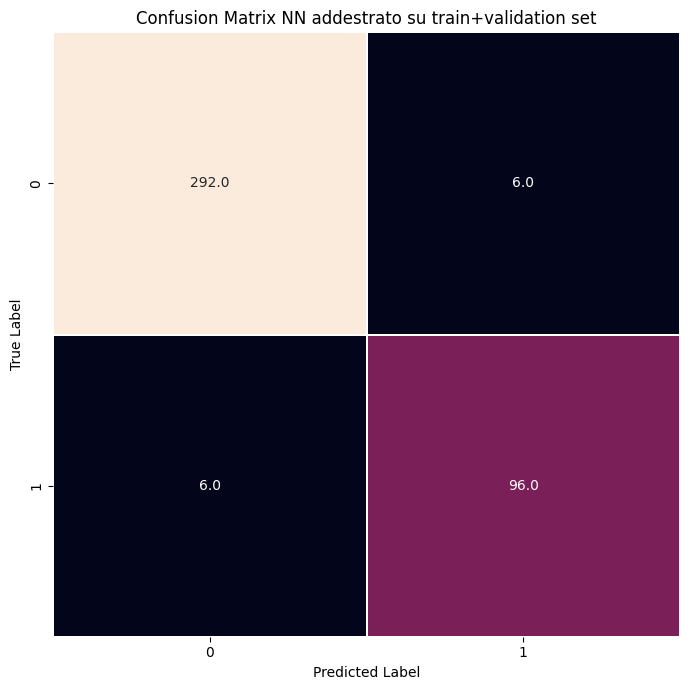

In [218]:
confmat = confusion_matrix(y_test, y_test_pred_valid)
# Plot the confusion matrix
f,ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confmat, annot=True, linewidths=0.02, cbar=False, fmt= '.1f',ax=ax)

plt.title("Confusion Matrix NN addestrato su train+validation set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

### Addestramento finale con l'intero dataset


In [219]:
X_final_dataset = dataset.drop("labels", axis=1)
y_final_dataset = dataset["labels"]
X_final_dataset.shape

(4000, 19200)

In [220]:
assert X_final_dataset.shape[0] == y_final_dataset.shape[0], "Final dataset and labels have different number of examples"

In [221]:
resample = True

undersampling_pos_proportion, oversampling_pos_proportion = 0.333, 0.4
undersampling_pos_to_neg_proportion = undersampling_pos_proportion / (1 - undersampling_pos_proportion)
oversampling_pos_to_neg_proportion = oversampling_pos_proportion / (1 - oversampling_pos_proportion)
undersampler = RandomUnderSampler(sampling_strategy=undersampling_pos_to_neg_proportion, random_state=RANDOM_STATE)
oversampler = RandomOverSampler(sampling_strategy=oversampling_pos_to_neg_proportion, random_state=RANDOM_STATE)

if resample:
    X_final_dataset, y_final_dataset = undersampler.fit_resample(X_final_dataset, y_final_dataset)
    X_final_dataset, y_final_dataset = oversampler.fit_resample(X_final_dataset, y_final_dataset)

In [222]:
pca_final_dataset = pca.transform(X_final_dataset)

In [223]:
model = Sequential()
model.add(Dense(best_nodes, input_shape=(n_components,), activation=best_activation_function))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(pca_final_dataset, y_final_dataset, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/22
668/668 [==============================] - 2s 2ms/step - loss: 0.5051 - accuracy: 0.8907
Epoch 2/22
668/668 [==============================] - 1s 2ms/step - loss: 0.1372 - accuracy: 0.9572
Epoch 3/22
668/668 [==============================] - 1s 2ms/step - loss: 0.0779 - accuracy: 0.9739
Epoch 4/22
668/668 [==============================] - 2s 3ms/step - loss: 0.0470 - accuracy: 0.9880
Epoch 5/22
668/668 [==============================] - 2s 3ms/step - loss: 0.0247 - accuracy: 0.9940
Epoch 6/22
668/668 [==============================] - 1s 2ms/step - loss: 0.0193 - accuracy: 0.9955
Epoch 7/22
668/668 [==============================] - 1s 2ms/step - loss: 0.0147 - accuracy: 0.9967
Epoch 8/22
668/668 [==============================] - 1s 2ms/step - loss: 0.0251 - accuracy: 0.9919
Epoch 9/22
668/668 [==============================] - 1s 2ms/step - loss: 0.0154 - accuracy: 0.9955
Epoch 10/22
668/668 [==============================] - 1s 2ms/step - loss: 0.0067 - accuracy: 0.9985

### Salvataggio del modello su disco

Salvataggio dei pesi in formato _h5_:

In [93]:
model.save_weights(NN_WEIGHTS_PATH)

Salvataggio delle configurazioni in formato _JSON_:

In [94]:
with open(NN_CONFIG_PATH, "w") as json_file:
    json_file.write(model.to_json())

# Modello 2 - SVM

## Tuning iperparametri

In [224]:
assert y_val.shape[0] == pca_X_val.shape[0], "Il numero di esempi nel validation set dopo la PCA è diverso dal numero di labels"

In [225]:
from sklearn import svm
from sklearn.metrics import f1_score, explained_variance_score

kernels_avaible = ['linear', 'rbf', 'poly', 'sigmoid']
kernels_f1 = []
kernels_explained_variance = []
for i, kernel in enumerate(kernels_avaible):
    print(f"Testing kernels: {kernel} ({i+1}/{len(kernels_avaible)}):")
    # Crea il classificatore SVM
    clf = svm.SVC(kernel=kernel, C=1, random_state=RANDOM_STATE)

    # Addestra il classificatore
    clf.fit(pca_X_train, resized_y_train)
    # Effettua le predizioni sul validation set
    y_pred = clf.predict(pca_X_val) #array di booleani, grande quanto il num di righe di pca_X_val

    kernels_f1.append(f1_score(y_val, y_pred))

    kernels_explained_variance.append(explained_variance_score(y_val, y_pred))
    print(f"f1 score: {kernels_f1[-1]:.3f}, Explained Variance: {kernels_explained_variance[-1]:.3f}")

Testing kernels: linear (1/4):
f1 score: 0.847, Explained Variance: 0.573
Testing kernels: rbf (2/4):
f1 score: 0.908, Explained Variance: 0.750
Testing kernels: poly (3/4):
f1 score: 0.702, Explained Variance: 0.399
Testing kernels: sigmoid (4/4):
f1 score: 0.518, Explained Variance: -0.499


In [226]:
best_kernel = kernels_avaible[np.argmax(kernels_f1)]
best_kernel

'rbf'

In [227]:
C_avaible = range(1,10)
C_f1 = []
C_explained_variance = []
for i, C in enumerate(C_avaible):
    print(f"Testing C: {C} ({i+1}/{len(C_avaible)}):")
    # Crea il classificatore SVM
    clf = svm.SVC(kernel=best_kernel, C=C, random_state=RANDOM_STATE)

    # Addestra il classificatore
    clf.fit(pca_X_train, resized_y_train)
    # Effettua le predizioni sul validation set
    y_pred = clf.predict(pca_X_val) #array di booleani, grande quanto il num di righe di pca_X_val

    C_f1.append(f1_score(y_val, y_pred))

    C_explained_variance.append(explained_variance_score(y_val, y_pred))
    print(f"f1 score: {C_f1[-1]:.3f}, Explained Variance: {C_explained_variance[-1]:.3f}")

Testing C: 1 (1/9):
f1 score: 0.908, Explained Variance: 0.750
Testing C: 2 (2/9):
f1 score: 0.919, Explained Variance: 0.783
Testing C: 3 (3/9):
f1 score: 0.915, Explained Variance: 0.770
Testing C: 4 (4/9):
f1 score: 0.915, Explained Variance: 0.770
Testing C: 5 (5/9):
f1 score: 0.922, Explained Variance: 0.791
Testing C: 6 (6/9):
f1 score: 0.927, Explained Variance: 0.804
Testing C: 7 (7/9):
f1 score: 0.924, Explained Variance: 0.797
Testing C: 8 (8/9):
f1 score: 0.927, Explained Variance: 0.804
Testing C: 9 (9/9):
f1 score: 0.924, Explained Variance: 0.797


In [228]:
best_C = C_avaible[np.argmax(C_f1)]
best_C

6

## __Stratified 10-fold cross validation__

In [229]:
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])
y = y_train_val

assert X_train_val.shape[0] == y_train_val.shape[0], "Training + validation set have different number of examples and labels"

pca_cross_dataset = pca.transform(X_train_val)
df = pd.DataFrame(data=pca_cross_dataset)

In [230]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, explained_variance_score
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import time

n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=RANDOM_STATE)

test_pred_proba = np.zeros((df.shape[0], 2))
accuracy_k_fold_svm = []
recall_k_fold_svm = []
precision_k_fold_svm = []
f1_k_fold_svm = []
explained_variance_k_fold_svm = []

timesAddestramento_svm = []
timesInferenza_svm = []

resample = False
undersampling_pos_proportion, oversampling_pos_proportion = 0.333, 0.4
undersampling_pos_to_neg_proportion = undersampling_pos_proportion / (1 - undersampling_pos_proportion)
oversampling_pos_to_neg_proportion = oversampling_pos_proportion / (1 - oversampling_pos_proportion)
undersampler = RandomUnderSampler(sampling_strategy=undersampling_pos_to_neg_proportion, random_state=RANDOM_STATE)
oversampler = RandomOverSampler(sampling_strategy=oversampling_pos_to_neg_proportion, random_state=RANDOM_STATE)

for n_fold, (train_idx, val_test_idx) in enumerate(folds.split(df, y)):
        X_cross_train, X_cross_val = df.iloc[train_idx], df.iloc[val_test_idx]
        y_cross_train, y_cross_val = y[train_idx], y[val_test_idx]

        if resample:
                X_cross_train, y_cross_train = undersampler.fit_resample(X_cross_train, y_cross_train)
                X_cross_train, y_cross_train = oversampler.fit_resample(X_cross_train, y_cross_train)

        # Crea il classificatore SVM
        clf = svm.SVC(kernel=best_kernel, C=best_C, random_state=RANDOM_STATE)
        tic = time.time()

        # Addestra il classificatore
        clf.fit(X_cross_train, y_cross_train)
        timesAddestramento_svm.append(time.time() - tic)

        tic = time.time()
        #fai inferenza sui dati di validation
        y_cross_pred_valid = clf.predict(X_cross_val)
        timesInferenza_svm.append(time.time() - tic)

        accuracy_k_fold_svm.append(accuracy_score(y_cross_val, y_cross_pred_valid))
        recall_k_fold_svm.append(recall_score(y_cross_val, y_cross_pred_valid))
        precision_k_fold_svm.append(precision_score(y_cross_val, y_cross_pred_valid))
        f1_k_fold_svm.append(f1_score(y_cross_val, y_cross_pred_valid))
        explained_variance_k_fold_svm.append(explained_variance_score(y_cross_val, y_cross_pred_valid))

        print(f'Fold {n_fold + 1}, Accuracy: {accuracy_k_fold_svm[-1]:.3f}, F1: {f1_k_fold_svm[-1]:.3f}, Explained Variance: {explained_variance_k_fold_svm[-1]:.3f}', end=", ")
        print(f'Training time: {timesAddestramento_svm[-1]:.3f}, Evaluation time: {timesInferenza_svm[-1]:.3f}')

Fold 1, Accuracy: 0.969, F1: 0.936, Explained Variance: 0.837, Training time: 0.281, Evaluation time: 0.042
Fold 2, Accuracy: 0.969, F1: 0.939, Explained Variance: 0.836, Training time: 0.279, Evaluation time: 0.043
Fold 3, Accuracy: 0.967, F1: 0.934, Explained Variance: 0.822, Training time: 0.285, Evaluation time: 0.045
Fold 4, Accuracy: 0.983, F1: 0.967, Explained Variance: 0.911, Training time: 0.267, Evaluation time: 0.045
Fold 5, Accuracy: 0.978, F1: 0.955, Explained Variance: 0.882, Training time: 0.280, Evaluation time: 0.042
Fold 6, Accuracy: 0.972, F1: 0.946, Explained Variance: 0.853, Training time: 0.257, Evaluation time: 0.045
Fold 7, Accuracy: 0.964, F1: 0.927, Explained Variance: 0.808, Training time: 0.266, Evaluation time: 0.043
Fold 8, Accuracy: 0.981, F1: 0.960, Explained Variance: 0.897, Training time: 0.277, Evaluation time: 0.047
Fold 9, Accuracy: 0.953, F1: 0.903, Explained Variance: 0.749, Training time: 0.245, Evaluation time: 0.020
Fold 10, Accuracy: 0.986, F1

In [231]:
print(f"Tempo medio di addestramento: {np.mean(timesAddestramento_svm):.2f} secondi")
print(f"Tempo medio di inferenza: {np.mean(timesInferenza_svm):.2f} secondi")

Tempo medio di addestramento: 0.26 secondi
Tempo medio di inferenza: 0.04 secondi


Metriche sul __validation test__ per la __stratified cross validation__:

In [232]:
accuracy = np.mean(accuracy_k_fold_svm)
recall = np.mean(recall_k_fold_svm)
precision = np.mean(precision_k_fold_svm)
f1 = np.mean(f1_k_fold_svm)
explained_variance = np.mean(explained_variance_k_fold_svm)
print(f"Accuracy={accuracy:.3f}, Recall={recall:.3f}, Precision={precision:.3f}, F1={f1:.3f}, Explained Variance={explained_variance:.3f}")

Accuracy=0.972, Recall=0.937, Precision=0.952, F1=0.944, Explained Variance=0.852


Intervalli di confidenza per tutte le metriche:

In [233]:
confidence = 0.95

import scipy.stats as stats

print(f"Accuracy {confidence} confidence interval: {stats.t.interval(confidence=confidence, df=len(accuracy_k_fold_svm)-1, loc=np.mean(accuracy_k_fold_svm), scale=stats.sem(accuracy_k_fold_svm))}")
print(f"Recall {confidence} confidence interval: {stats.t.interval(confidence=confidence, df=len(recall_k_fold_svm)-1, loc=np.mean(recall_k_fold_svm), scale=stats.sem(recall_k_fold_svm))}")
print(f"Precision {confidence} confidence interval: {stats.t.interval(confidence=confidence, df=len(precision_k_fold_svm)-1, loc=np.mean(precision_k_fold_svm), scale=stats.sem(precision_k_fold_svm))}")
print(f"F1 {confidence} confidence interval: {stats.t.interval(confidence=confidence, df=len(f1_k_fold_svm)-1, loc=np.mean(f1_k_fold_svm), scale=stats.sem(f1_k_fold_svm))}") # dopo lo plottiamo pure
print(f"Explained Variance {confidence} confidence interval: {stats.t.interval(confidence=confidence, df=len(explained_variance_k_fold_svm)-1, loc=np.mean(explained_variance_k_fold_svm), scale=stats.sem(explained_variance_k_fold_svm))}")

Accuracy 0.95 confidence interval: (0.9650270694053453, 0.9794173750390989)
Recall 0.95 confidence interval: (0.9155678668391081, 0.9574408722370467)
Precision 0.95 confidence interval: (0.9349386179028966, 0.9685301116791108)
F1 0.95 confidence interval: (0.928963693610848, 0.9586128023301949)
Explained Variance 0.95 confidence interval: (0.8137640815312512, 0.890357398435109)


## __Addestramento__ con l'intero __training set__

In [234]:
assert X_train_val.shape[0] == y_train_val.shape[0], "Training + validation set have different number of examples and labels"

resample = True
undersampling_pos_proportion, oversampling_pos_proportion = 0.333, 0.4
undersampling_pos_to_neg_proportion = undersampling_pos_proportion / (1 - undersampling_pos_proportion)
oversampling_pos_to_neg_proportion = oversampling_pos_proportion / (1 - oversampling_pos_proportion)
undersampler = RandomUnderSampler(sampling_strategy=undersampling_pos_to_neg_proportion, random_state=RANDOM_STATE)
oversampler = RandomOverSampler(sampling_strategy=oversampling_pos_to_neg_proportion, random_state=RANDOM_STATE)

if resample:
    X_train_val, y_train_val = undersampler.fit_resample(X_train_val, y_train_val)
    X_train_val, y_train_val = oversampler.fit_resample(X_train_val, y_train_val)

pca_train_dataset = pca.transform(X_train_val)

model = svm.SVC(kernel=best_kernel, C=best_C, random_state=RANDOM_STATE, probability=True) #nota il probability=True, perchè vogliamo (con la NN di sopra) output reale e non già sogliato sulla threshold che decide lui (ci serve dopo per le varie curve)

# Addestra il classificatore
model.fit(pca_train_dataset, y_train_val)

SVC(C=6, probability=True, random_state=57)

## Test finale sul test-set e matrice di confusione



In [235]:
y_test_pred_prob_svm = model.predict_proba(pca_X_test)[:, 1]
threshold = 0.5
y_test_pred_valid = (y_test_pred_prob_svm > threshold).astype(int)

accuracy_svm = accuracy_score(y_test, y_test_pred_valid)
recall_svm = recall_score(y_test, y_test_pred_valid)
precision_svm = precision_score(y_test, y_test_pred_valid)
f1_svm = f1_score(y_test, y_test_pred_valid)
explained_variance_svm = explained_variance_score(y_test, y_test_pred_valid)

print(f"Accuracy={accuracy_svm:.3f}, Recall={recall_svm:.3f}, Precision={precision_svm:.3f}, F1={f1_svm:.3f}, Explained Variance={explained_variance_svm:.3f}")

Accuracy=0.955, Recall=0.922, Precision=0.904, F1=0.913, Explained Variance=0.763


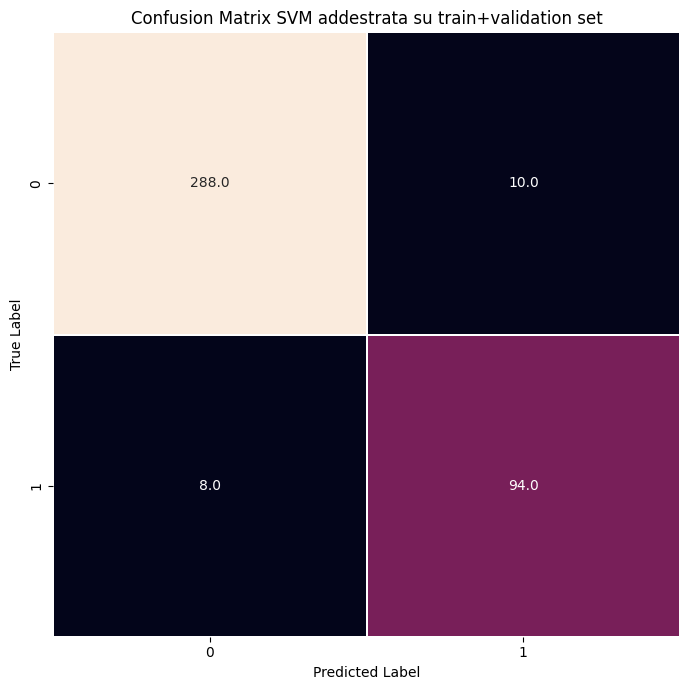

In [236]:

confmat = confusion_matrix(y_test, y_test_pred_valid)
# Plot the confusion matrix
f,ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confmat, annot=True, linewidths=0.02, cbar=False, fmt= '.1f',ax=ax)

plt.title("Confusion Matrix SVM addestrata su train+validation set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## Addestramento finale con l'intero dataset e salvataggio su disco

In [108]:
X_final_dataset = dataset.drop("labels", axis=1)
y_final_dataset = dataset["labels"]
X_final_dataset.shape

assert X_final_dataset.shape[0] == y_final_dataset.shape[0], "Final dataset and labels have different number of examples"

resample = True

undersampling_pos_proportion, oversampling_pos_proportion = 0.333, 0.4
undersampling_pos_to_neg_proportion = undersampling_pos_proportion / (1 - undersampling_pos_proportion)
oversampling_pos_to_neg_proportion = oversampling_pos_proportion / (1 - oversampling_pos_proportion)
undersampler = RandomUnderSampler(sampling_strategy=undersampling_pos_to_neg_proportion, random_state=RANDOM_STATE)
oversampler = RandomOverSampler(sampling_strategy=oversampling_pos_to_neg_proportion, random_state=RANDOM_STATE)

if resample:
    X_final_dataset, y_final_dataset = undersampler.fit_resample(X_final_dataset, y_final_dataset)
    X_final_dataset, y_final_dataset = oversampler.fit_resample(X_final_dataset, y_final_dataset)

pca_final_dataset = pca.transform(X_final_dataset)

model = svm.SVC(kernel=best_kernel, C=best_C, random_state=RANDOM_STATE)
model.fit(pca_final_dataset, y_final_dataset)


# salvo modello addestrato su disco
with open(SVM_MODEL_DUMP_PATH,'wb') as f:
    pickle.dump(model,f)

# per caricare (se si vuole fare inferenza in ambiente di produzione) il modello addestrato:
# with open(SVM_MODEL_DUMP_PATH, 'rb') as f:
#     model = pickle.load(f)


## Comparazione delle performance dei due modelli sulle rispettive __10-fold cross validation__

__Metriche__:

NN metrics mean: [0.9713888888888889, 0.9509862671660425, 0.9360198786307381, 0.9433305503745878]
SVM metrics mean: [0.9722222222222221, 0.9365043695380774, 0.9517343647910037, 0.9437882479705214]
NN metrics intervals: [(0.9595753272074573, 0.9832024505703204), (0.9310561446686508, 0.9709163896634342), (0.9085102670058008, 0.9635294902556754), (0.9204589378760564, 0.9662021628731192)]
SVM metrics intervals: [(0.9650270694053453, 0.9794173750390989), (0.9155678668391081, 0.9574408722370467), (0.9349386179028966, 0.9685301116791108), (0.928963693610848, 0.9586128023301949)]


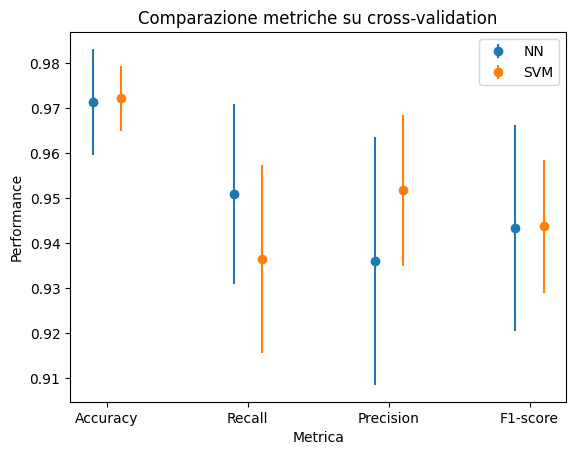

In [237]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

metrics = ['Accuracy', "Recall", "Precision", "F1-score"]
nn_metrics_mean = []
nn_metrics_intervals = []
svm_metrics_mean = []
svm_metrics_intervals = []

# Calculate metrics for nn
[nn_metrics_mean.append(np.mean(metric)) for metric in (accuracy_k_fold, recall_k_fold, precision_k_fold, f1_k_fold)]

# Calculate intervals for nn
[nn_metrics_intervals.append(stats.t.interval(0.95, len(metric)-1, loc=np.mean(metric), scale=stats.sem(metric))) for metric in (accuracy_k_fold, recall_k_fold, precision_k_fold, f1_k_fold)]
nn_errors = [(interval[1] - interval[0]) / 2 for interval in nn_metrics_intervals]

# Calculate metrics for svm
[svm_metrics_mean.append(np.mean(metric)) for metric in (accuracy_k_fold_svm, recall_k_fold_svm, precision_k_fold_svm, f1_k_fold_svm)]

# Calculate intervals for svm
[svm_metrics_intervals.append(stats.t.interval(0.95, len(metric)-1, loc=np.mean(metric), scale=stats.sem(metric))) for metric in (accuracy_k_fold_svm, recall_k_fold_svm, precision_k_fold_svm, f1_k_fold_svm)]
svm_errors = [(interval[1] - interval[0]) / 2 for interval in svm_metrics_intervals]

print(f"NN metrics mean: {nn_metrics_mean}")
print(f"SVM metrics mean: {svm_metrics_mean}")
print(f"NN metrics intervals: {nn_metrics_intervals}")
print(f"SVM metrics intervals: {svm_metrics_intervals}")

models = ["NN", "SVM"]
means = [nn_metrics_mean, svm_metrics_mean]
errors = [nn_errors, svm_errors]

for i, model in enumerate(models):
  x_pos = np.arange(len(metrics)) + i * 0.2  # Posizione x per ogni modello
  plt.errorbar(x_pos, means[i], yerr=errors[i], fmt='o', label=model)


plt.xticks(np.arange(len(metrics)) + 0.1, metrics)
plt.ylabel('Performance')
plt.xlabel('Metrica')
plt.title('Comparazione metriche su cross-validation')
plt.legend()

plt.show()

Curva __ROC__:

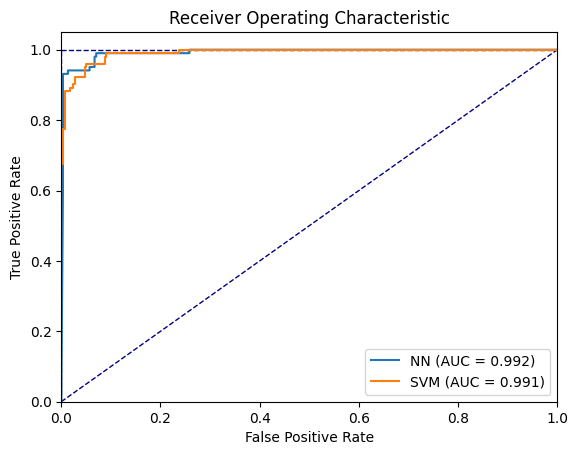

In [238]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_test_pred_prob_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)

fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_test_pred_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
plt.plot([0, 0], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot([0, 1], [1, 1], color='navy', lw=1, linestyle='--')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

# Plotta la curva ROC dei due modelli per comparare le performance

plt.plot(fpr_nn, tpr_nn, label=f'NN (AUC = {roc_auc_nn:.3f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Curva __Precision-Recall__:

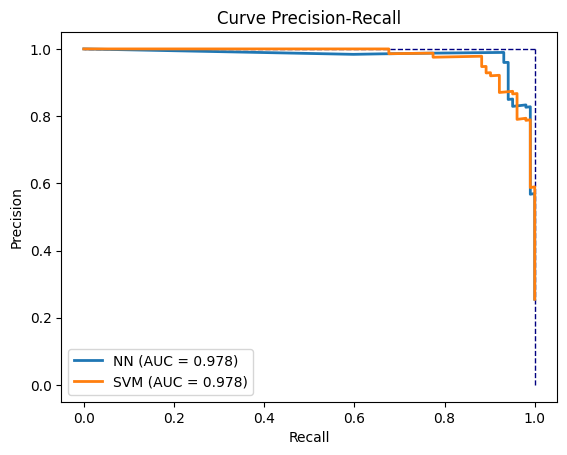

In [240]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision_nn_threshold, recall_nn_threshold, thresholds_nn = precision_recall_curve(y_test, y_test_pred_prob_nn)
prec_rec_auc_nn = auc(recall_nn_threshold, precision_nn_threshold)

precision_svm_threshold, recall_svm_threshold, thresholds_svm = precision_recall_curve(y_test, y_test_pred_prob_svm)
prec_rec_auc_svm = auc(recall_svm_threshold, precision_svm_threshold)

plt.plot([1, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot([1, 0], [1, 1], color='navy', lw=1, linestyle='--')
plt.plot(recall_nn_threshold, precision_nn_threshold, lw=2, label='NN (AUC = %0.3f)' % prec_rec_auc_nn)
plt.plot(recall_svm_threshold, precision_svm_threshold, lw=2, label='SVM (AUC = %0.3f)' % prec_rec_auc_svm)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curve Precision-Recall')
plt.legend(loc="lower left")
plt.show()

In [241]:
min_precision, delta = 0.8, 0.025
crit_precisions = [min_precision + delta * i for i in range(int((1 - min_precision) / delta) + 1)]
crit_thresholds = []

max_recalls = []

for prec in crit_precisions:
    index = np.argmax(precision_nn_threshold >= prec)
    max_recalls.append(recall_nn_threshold[index])
    crit_thresholds.append(thresholds_nn[index])

# Create a dataframe with the precision and maximum recall values
df = pd.DataFrame({'Threshold': crit_thresholds,'Precision': crit_precisions, 'Recall': max_recalls})
print("Precision vs Recall a vari livelli della soglia decisionale per il modello NN")
df

Precision vs Recall a vari livelli della soglia decisionale per il modello NN


,Threshold,Precision,Recall
0,0.004863,0.800,0.990196
1,0.010082,0.825,0.990196
2,0.051488,0.850,0.950980
3,0.116382,0.875,0.941176
4,0.271101,0.900,0.941176
5,0.450683,0.925,0.941176
6,0.779892,0.950,0.941176
7,0.969677,0.975,0.931373


In [242]:
min_precision, delta = 0.8, 0.025
crit_precisions = [min_precision + delta * i for i in range(int((1 - min_precision) / delta) + 1)]
crit_thresholds = []

max_recalls = []

for prec in crit_precisions:
    index = np.argmax(precision_svm_threshold >= prec)
    max_recalls.append(recall_svm_threshold[index])
    crit_thresholds.append(thresholds_svm[index])

# Create a dataframe with the precision and maximum recall values
df = pd.DataFrame({'Threshold': crit_thresholds,'Precision': crit_precisions, 'Recall': max_recalls})
print("Precision vs Recall a vari livelli della soglia decisionale per il modello SVM")
df

Precision vs Recall a vari livelli della soglia decisionale per il modello SVM


,Threshold,Precision,Recall
0,0.141643,0.800,0.960784
1,0.189218,0.825,0.960784
2,0.218156,0.850,0.960784
3,0.431608,0.875,0.921569
4,0.525730,0.900,0.921569
5,0.705332,0.925,0.901961
6,0.866442,0.950,0.882353
7,0.880415,0.975,0.882353


Comparazione performance su __test-set__ della rete neurale tra __gray-scale__ e __RGB__:

[[0.968, 0.931, 0.941, 0.936], [0.97, 0.9411764705882353, 0.9411764705882353, 0.9411764705882353]]


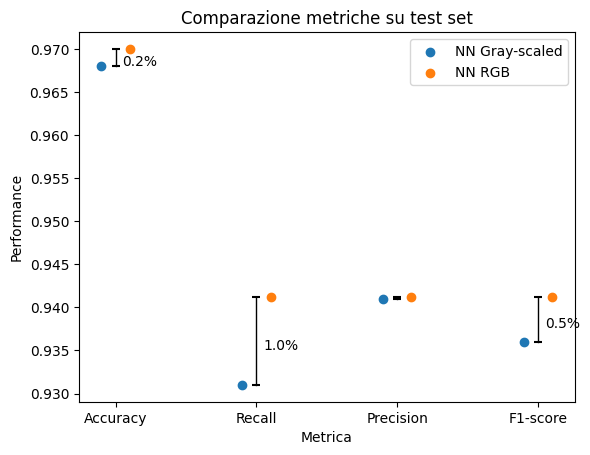

In [254]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ['Accuracy', "Recall", "Precision", "F1-score"]
nn_test_metrics = [0.968, 0.931, 0.941, 0.936]
nn_rgb_test_metrics = [float(accuracy_nn), float(recall_nn), float(precision_nn), float(f1_nn)]

models = ["NN Gray-scaled", "NN RGB"]
test_results = [nn_test_metrics, nn_rgb_test_metrics]

print(test_results)

for i, model in enumerate(models):
    x_pos = np.arange(len(metrics)) + i * 0.2  # Posizione x per ogni modello
    plt.scatter(x_pos, test_results[i], label=model)

x_pos = np.arange(len(metrics)) + 0.1
for i, x in enumerate(x_pos):
    y_values = [min(test_results[0][i], test_results[1][i]), max(test_results[0][i], test_results[1][i])]
    plt.plot([x, x], y_values, color='black', lw=1)
    plt.scatter([x, x], y_values, color='black', marker='_')
    diff = np.abs(test_results[0][i] - test_results[1][i])
    if diff > 0.001:
        plt.text(x + 0.05, (test_results[0][i] + test_results[1][i]) / 2 - 0.001, f'{(diff*100):.1f}%', rotation=0)

plt.xticks(np.arange(len(metrics)) + 0.1, metrics)
plt.ylabel('Performance')
plt.xlabel('Metrica')
plt.title('Comparazione metriche su test set')
plt.legend()

plt.show()

Comparazione performance su __test-set__ della SVM tra __gray-scale__ e __RGB__:

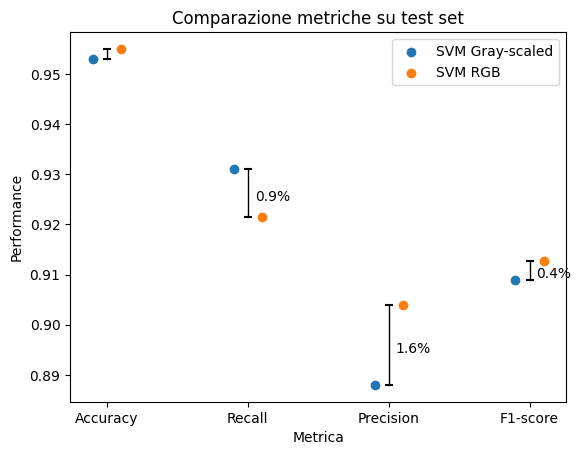

In [252]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ['Accuracy', "Recall", "Precision", "F1-score"]
svm_test_metrics = [0.953, 0.931, 0.888, 0.909]
svm_rgb_test_metrics = [accuracy_svm, recall_svm, precision_svm, f1_svm]

models = ["SVM Gray-scaled", "SVM RGB"]
test_results = [svm_test_metrics, svm_rgb_test_metrics]

for i, model in enumerate(models):
    x_pos = np.arange(len(metrics)) + i * 0.2  # Posizione x per ogni modello
    plt.scatter(x_pos, test_results[i], label=model)

x_pos = np.arange(len(metrics)) + 0.1
for i, x in enumerate(x_pos):
    y_values = [min(test_results[0][i], test_results[1][i]), max(test_results[0][i], test_results[1][i])]
    plt.plot([x, x], y_values, color='black', lw=1)
    plt.scatter([x, x], y_values, color='black', marker='_')
    diff = np.abs(test_results[0][i] - test_results[1][i])
    if diff > 0.003:
        plt.text(x + 0.05, (test_results[0][i] + test_results[1][i]) / 2 - 0.0015, f'{(diff*100):.1f}%', rotation=0)

plt.xticks(np.arange(len(metrics)) + 0.1, metrics)
plt.ylabel('Performance')
plt.xlabel('Metrica')
plt.title('Comparazione metriche su test set')
plt.legend()

plt.show()

Comparazione dei tempi di addestramento su __cross-validation__:

NN rgb metrics mean: [21.337312030792237, 4.211584353446961]
SVM rgb metrics mean: [0.26196234226226806, 0.040483617782592775]
NN rgb metrics intervals: [(15.507931075705851, 27.166692985878623), (-0.09754649771167667, 8.520715204605597)]
SVM rgb metrics intervals: [(0.2399711979721374, 0.2839534865523987), (0.03472101329743665, 0.0462462222677489)]
[0. 1.]
[17.500384998321532, 2.865693998336792]
[0.1 1.1]
[21.337312030792237, 4.211584353446961]
[0.2 1.2]
[0.1915947675704956, 0.02462303638458252]
[0.3 1.3]
[0.26196234226226806, 0.040483617782592775]


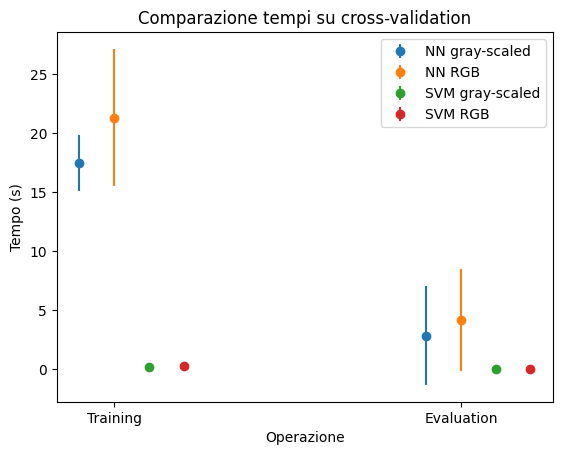

In [253]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

confidence = 0.95

operations = ['Training', 'Evaluation']
nn_gray_times_mean = [17.500384998321532, 2.865693998336792]
nn_gray_times_intervals = [(15.129273229316645, 19.87149676732642), (-1.3142737236867204, 7.045661720360305)]
nn_rgb_times_mean = []
nn_rgb_times_intervals = []
svm_gray_times_mean = [0.1915947675704956, 0.02462303638458252]
svm_gray_times_intervals = [(0.18274292621413238, 0.2004466089268588), (0.023336935882528033, 0.025909136886637006)]
svm_rgb_times_mean = []
svm_rgb_times_intervals = []

nn_gray_errors = [(interval[1] - interval[0]) / 2 for interval in nn_gray_times_intervals]

# Calculate times for nn
[nn_rgb_times_mean.append(np.mean(times)) for times in (timesAddestramento, timesInferenza)]

# Calculate intervals for nn
[nn_rgb_times_intervals.append(stats.t.interval(confidence, len(times)-1, loc=np.mean(times), scale=stats.sem(times))) for times in (timesAddestramento, timesInferenza)]
nn_rgb_errors = [(interval[1] - interval[0]) / 2 for interval in nn_rgb_times_intervals]

svm_gray_errors = [(interval[1] - interval[0]) / 2 for interval in svm_gray_times_intervals]

# Calculate metrics for svm
[svm_rgb_times_mean.append(np.mean(times)) for times in (timesAddestramento_svm, timesInferenza_svm)]

# Calculate intervals for svm
[svm_rgb_times_intervals.append(stats.t.interval(confidence, len(times)-1, loc=np.mean(times), scale=stats.sem(times))) for times in (timesAddestramento_svm, timesInferenza_svm)]
svm_rgb_errors = [(interval[1] - interval[0]) / 2 for interval in svm_rgb_times_intervals]

print(f"NN rgb metrics mean: {nn_rgb_times_mean}")
print(f"SVM rgb metrics mean: {svm_rgb_times_mean}")
print(f"NN rgb metrics intervals: {nn_rgb_times_intervals}")
print(f"SVM rgb metrics intervals: {svm_rgb_times_intervals}")

models = ["NN gray-scaled", "NN RGB", "SVM gray-scaled", "SVM RGB"]
means = [nn_gray_times_mean, nn_rgb_times_mean, svm_gray_times_mean, svm_rgb_times_mean]
errors = [nn_gray_errors, nn_rgb_errors, svm_gray_errors, svm_rgb_errors]

for i, model in enumerate(models):
  x_pos = np.arange(len(operations)) + i * 0.1
  print(x_pos)
  print(means[i])
  plt.errorbar(x_pos, means[i], yerr=errors[i], fmt='o', label=model)

plt.xticks(np.arange(len(operations)) + 0.1, operations)
plt.ylabel('Tempo (s)')
plt.xlabel('Operazione')
plt.title('Comparazione tempi su cross-validation')
plt.legend()

plt.show()